Source: https://www.kaggle.com/kmader/parkinsons-drawings
Orignial data from: Zham P, Kumar DK, Dabnichki P, Poosapadi Arjunan S and Raghav S (2017) Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral. Front. Neurol. 8:435. doi: 10.3389/fneur.2017.00435

As suggested by the author of the Kernal who I forked from, Kevin Mader, there are a couple of interesting analyses that could be performed on this dataset:

1. Try and order the curves and get realistic (if possibly inaccurate) trajectories for the pen movement
2. Quantify the pressure by looking at the thickness of the skeleton at specific points.
3. Start to quantify the 'jigglyness' of the motion (fourier analysis of the time series?, differential motion (local curvature?)

Looking at the curves, this is an interesting image processing problem.

TODO: Map trajectory of path, indexed labelled x, y positions for potential first to last pen movement. Dilation grow but restricted to segmented path?
Use this to then correlate jitteryness after plotting index vs x, y . Or measure difference in distance from prvious data points.
Can we build a feature set to be used for classification. Compare with DL classifier. Advantage we also get understanding from random forest classifier with feature engineering. 

In [1]:
# PLOTTING STYLE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
#plt.rcParams['axes.labelcolor'] = 'white'
plt.style.use('ggplot')
%matplotlib notebook

In [2]:
import numpy as np
from skimage.io import imread
from skimage.util import montage as montage2d
from skimage.morphology import skeletonize
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk, diamond
from skimage.morphology import label as sk_label #ndimage has function label as well with different call
from skimage.morphology import opening, closing
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize
from skimage import draw
from scipy import ndimage
import networkx as nx
from IPython.display import Image
import pandas as pd
from pathlib import Path
data_dir = Path(r'D:\Docs\Python_code\ParkinsonsSketch\178338_401677_bundle_archive\drawings')

# Organize Data
We will store our data in a pandas dataframe. We can also categorize the data based on the directory path name. The files are organized such that we have {spiral-wave\train-test\healthy-parkinson}. As you can see we can therefor organize by the type of drawing, training or testing for later classification, and the class label for the prediction.

In [3]:
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df['activity'] = draw_df['path'].map(lambda x: x.parent.parent.parent.stem)
print(draw_df.shape, 'images loaded')
draw_df.sample(3)

(204, 5) images loaded


,path,img_id,disease,validation,activity
176,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V03PO08,parkinson,training,wave
2,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V03HE1,healthy,testing,spiral
5,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V06HE01,healthy,testing,spiral


# Display Images
Apply some preprocessing

In [4]:
def process_imread(in_path, resize=True):
    """read images, invert and scale them"""
    c_img = 1.0-imread(in_path, as_gray=True)
    max_dim = np.max(c_img.shape)
    if not resize:
        return c_img
    if c_img.shape==(256, 256):
        return c_img
    if max_dim>256:
        big_dim = 512
    else:
        big_dim = 256
    """ pad with zeros and center image, sizing to either 256 or 512"""   
    out_img = np.zeros((big_dim, big_dim), dtype='float32')
    c_offset = (big_dim-c_img.shape[0])//2
    d_offset = c_img.shape[0]+c_offset
    
    e_offset = (big_dim-c_img.shape[1])//2
    f_offset = c_img.shape[1]+e_offset
    out_img[c_offset:d_offset, e_offset:f_offset] = c_img[:(d_offset-c_offset), :(f_offset-e_offset)]
    return out_img

![example resizing](images/img_resize.png)

Next, we create a mosaic or montage of plots to show images. We group the images by their activity ie spiral or wave and if the drawer suffered from parkinsons or not. We take the first 9 images per montage image.

<IPython.core.display.Javascript object>


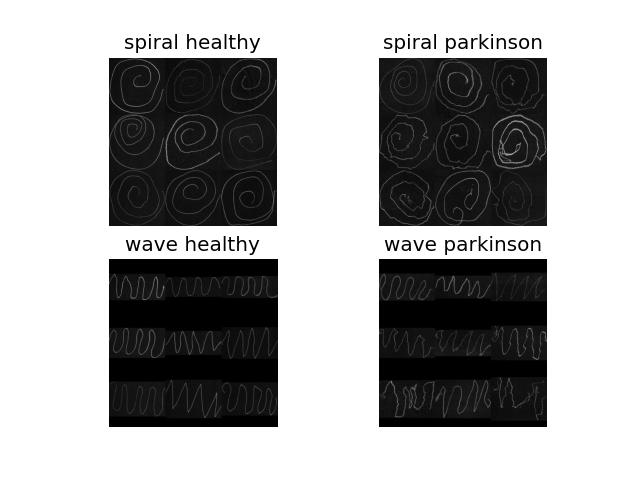

In [5]:
fig, m_axs = plt.subplots(2, 2)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([process_imread(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')
plt.savefig(r'images\raw_samples.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

# Filter and Segment
We can do some preprocessing to get just the drawn path

In [6]:
def read_and_thresh(in_path, resize=True):
    c_img = process_imread(in_path, resize=resize)
    c_img = (255*c_img).clip(0, 255).astype('uint8')
    c_img = median(c_img, disk(1))
    c_thresh = thresh_func(c_img)
    return c_img>c_thresh

In [7]:
disk(1)

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

<IPython.core.display.Javascript object>


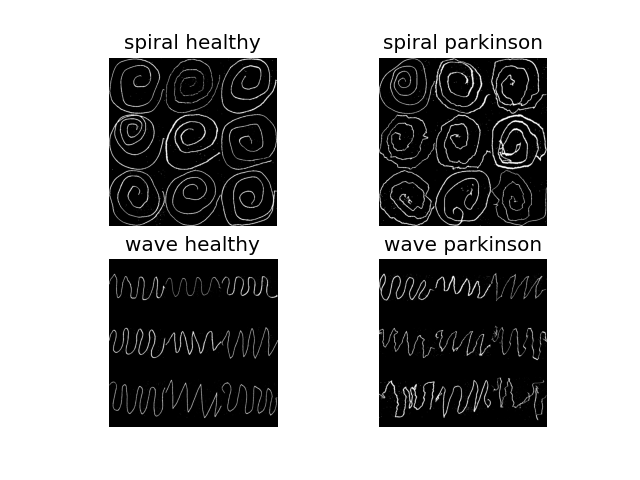

In [8]:
fig, m_axs = plt.subplots(2, 2)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([read_and_thresh(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')
plt.savefig(r'images\threshold_sample.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

In [9]:
%%time
# run all images, don't resize if not going to plot in montage
draw_df['thresh_img'] = draw_df['path'].map(lambda x: read_and_thresh(x, resize=False))

Wall time: 3.01 s


# Clean
Keep only large enough components that are >1% of activated pixels; defined by cutoff. First label each separate object in image and sum the areas for each label identified (that isn't 0). Keep the index if the count is more than 1% of the total. Perform negative sort to have the largest objects with label 1. Replace the old label number with the new ordered id.

In [10]:
def label_sort(in_img, cutoff=0.01):
    total_cnt = np.sum(in_img>0)
    lab_img = sk_label(in_img)
    new_image = np.zeros_like(lab_img)
    remap_index = []
    for k in np.unique(lab_img[lab_img>0]):
        cnt = np.sum(lab_img==k) # get area of labelled object
        if cnt>total_cnt*cutoff:
            remap_index+=[(k, cnt)]
    sorted_index = sorted(remap_index, key=lambda x: -x[1]) # reverse sort - largest is first
    for new_idx, (old_idx, idx_count) in enumerate(sorted_index, 1): #enumerate starting at id 1
        new_image[lab_img==old_idx] = new_idx
    return new_image

<IPython.core.display.Javascript object>


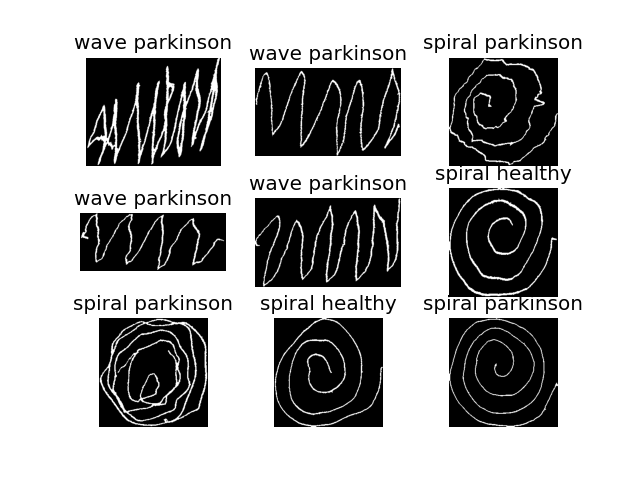

In [11]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9, random_state = 1).iterrows()):
    clean_img = closing(label_sort(c_row['thresh_img'])>0, disk(1))
    c_ax.imshow(clean_img, cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')
plt.savefig(r'images\thresh_cleaned_sample.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

In [12]:
%%time
draw_df['clean_img'] = draw_df['thresh_img'].map(lambda x: closing(label_sort(x)>0, disk(1)))

Wall time: 6.71 s


# Convert to table
Convert all the skeletonized plots to a dataframe where each row is a single data point for each image pixel.  

<IPython.core.display.Javascript object>


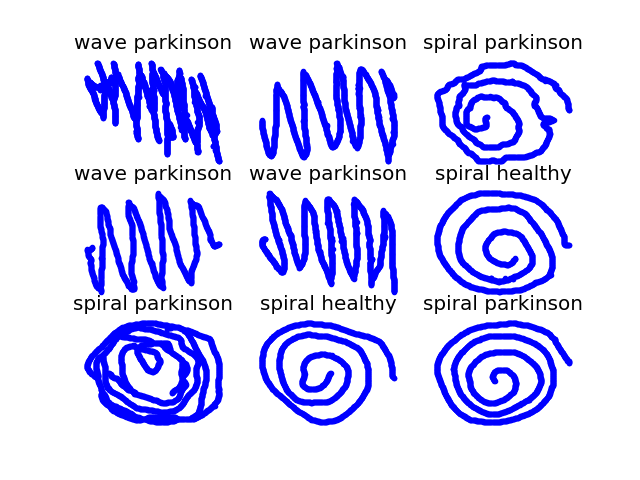

In [13]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9, random_state = 1).iterrows()):
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    
    c_ax.plot(skel_x, skel_y, 'b.')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

In [14]:
all_row_list = []
for _, c_row in draw_df.iterrows():
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    for x, y in zip(skel_x, skel_y):
        d_row = dict(**{k: v for k,v in c_row.items() if len(np.shape(v))<1})
        d_row['x'] = x
        d_row['y'] = y
        all_row_list += [d_row]

In [15]:
all_row_df = pd.DataFrame(all_row_list)
all_row_df.sample(3)

,path,img_id,disease,validation,activity,x,y
79216,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V12HE03,healthy,training,spiral,0.320312,0.402344
262943,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V55HO06,healthy,training,wave,0.427734,0.558621
227694,D:\Docs\Python_code\ParkinsonsSketch\178338_40...,V06HO03,healthy,training,wave,0.089844,0.284615


# Show all drawings on same plot
By plotting the skeleton pixels as points and rescaling we can overlay all of the images on top of each other for better visualization. The healthy patients are significantly more consistent than the Parkinson's.

<IPython.core.display.Javascript object>


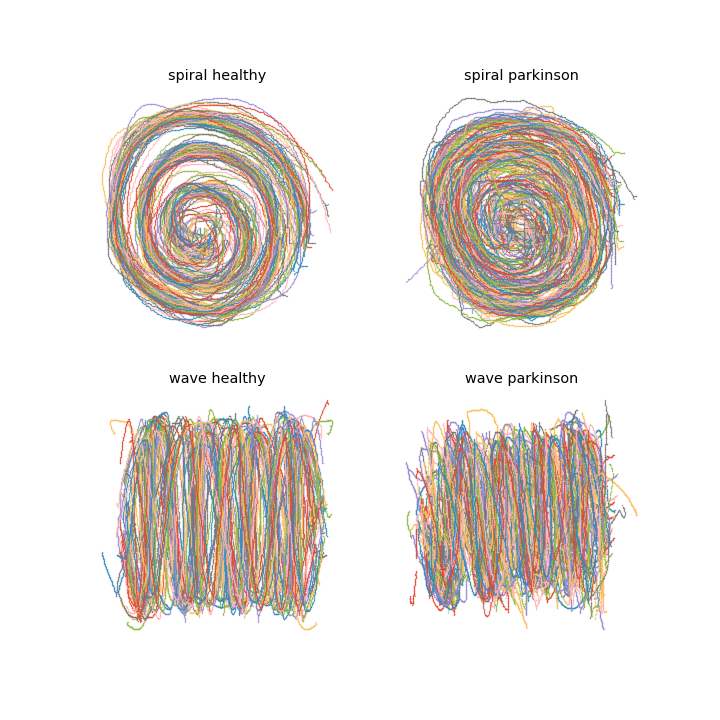

In [16]:
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10), dpi=72)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), all_row_df.groupby(['activity', 'disease'])):
    for c_id, d_rows in c_rows.groupby('img_id'):
        mean_std = np.mean([d_rows['x'].std(), d_rows['y'].std()])
        c_ax.plot((d_rows['x']-d_rows['x'].mean())/mean_std, 
                  (d_rows['y']-d_rows['y'].mean())/mean_std, '.', label=c_id, ms=0.75)
    #c_ax.legend()
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')
plt.savefig(r'images\all_one_plot.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

# Pen thickness quantification
Distance map and skeleton ridge + std to account for any inconsistent pen thickness from varying pressure applied.

In [17]:
def stroke_thickness_img(in_img):
    skel, distance = medial_axis(in_img, return_distance=True)
    skeleton = skeletonize(in_img)
    # Distance to the background for pixels of the skeleton
    return distance * skeleton

<IPython.core.display.Javascript object>


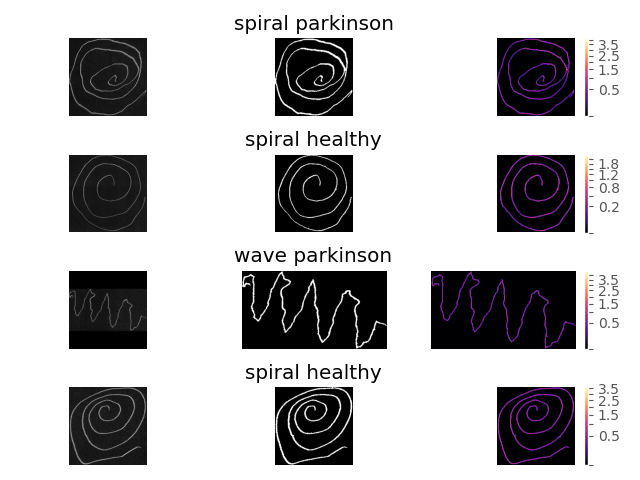

In [18]:
i = 0
fig, m_axs = plt.subplots(4, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(4, random_state = 2).iterrows()):

    dist_img = stroke_thickness_img(c_row['clean_img'])
    
    cset1 = m_axs[i,2].imshow(dist_img, cmap='magma', norm=mpl.colors.PowerNorm(gamma=0.5))
    cbar = fig.colorbar(cset1, ax=m_axs[i,2], format= '%.1f')
    for label in cbar.ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    m_axs[i,2].axis('off')
    
    cset2 = m_axs[i,1].imshow(c_row['clean_img'],cmap='gray')
    m_axs[i,1].set_title('{activity} {disease}'.format(**c_row))
    m_axs[i,1].axis('off')
    
    cset3 = m_axs[i,0].imshow(process_imread(c_row['path']),cmap='gray')
    m_axs[i,0].axis('off')
    
    i += 1
    fig.tight_layout()

Edit slightly to return only values which are above 0 and store

In [19]:
def stroke_thickness(in_img):
    skel, distance = medial_axis(in_img, return_distance=True)
    skeleton = skeletonize(in_img)
    # Distance to the background for pixels of the skeleton
    dist = distance * skeleton
    return dist[dist>0]

In [20]:
%%time
draw_df['thickness'] = draw_df['clean_img'].map(lambda x: stroke_thickness(x))

Wall time: 18.8 s


In [21]:
draw_df['mean_thickness'] = draw_df['thickness'].apply(np.mean)
draw_df['std_thickness'] = draw_df['thickness'].apply(np.std)

In [22]:
draw_df.groupby(['activity', 'disease'])['mean_thickness'].mean()

activity  disease  
spiral    healthy      1.894230
          parkinson    1.879122
wave      healthy      2.559639
          parkinson    2.819350
Name: mean_thickness, dtype: float64

In [23]:
draw_df.groupby(['activity', 'disease'])['std_thickness'].mean()

activity  disease  
spiral    healthy      0.428052
          parkinson    0.524317
wave      healthy      0.518404
          parkinson    0.709551
Name: std_thickness, dtype: float64

<IPython.core.display.Javascript object>


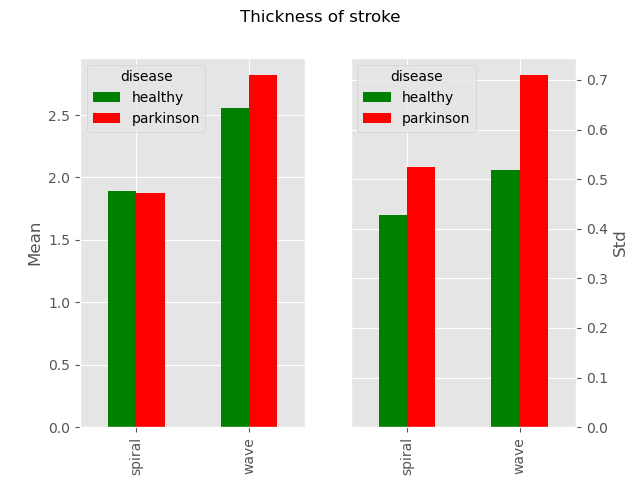

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=2)
plt.suptitle('Thickness of stroke')
draw_df.groupby(['activity','disease'])['mean_thickness'].mean().unstack().plot(kind='bar', legend=True, 
                                                                                color=['g', 'r'], ax = ax[0])
ax[0].set_ylabel("Mean")
draw_df.groupby(['activity','disease'])['std_thickness'].mean().unstack().plot(kind='bar', legend=True, 
                                                                               color=['g', 'r'], ax = ax[1])
ax[1].set_ylabel("Std")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()
# plt.savefig(r'images\thickness_plot.png', dpi=150, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

Interestingly enough we can see that on average the thickness is greater for Parkinsons patients but more so the variation in the thickness, indicating the inconsistent hand movements so often associated with the disease. Both these results are however impacted by some drawings that overlap the spiral or wave lines, and therefore increasing the 'thickness'.The jittery-ness will also increase the apparent thickness of the stroke. Looking at the examples above I think you will see what I mean, so it is not just pen pressure that is being captured but a combination of pen pressure, as well as inconsistency with the drawing movement. 

## Finding end-points

In [24]:
k_nn = np.array([[1,1,1],[1,0,1],[1,1,1]])
k_cross = np.array([[0,1,0],[1,0,1],[0,1,0]])

Test on one image

In [44]:
c_id ='V07PO02'
img = np.where(draw_df.loc[draw_df['img_id'] == c_id]['clean_img'].values[0] == True, 1, 0).astype(np.uint8)

In [41]:
def skeleton_drawing(in_img, k):
    edge_img = skeletonize(in_img, method='lee')
    return (edge_img > 0).astype(np.uint8)

In [46]:
img_skel = skeleton_drawing(img, k_nn)

<IPython.core.display.Javascript object>


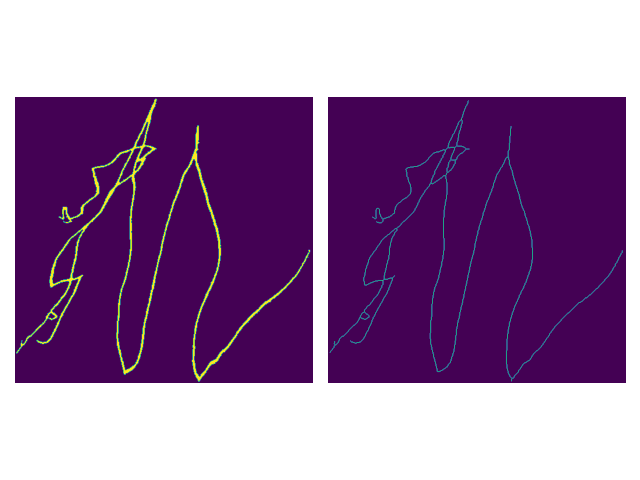

In [47]:
fig, m_axs = plt.subplots(1,2)
m_axs[0].imshow(img)
m_axs[0].axis('off')
m_axs[1].imshow(img_skel)
m_axs[1].axis('off')
plt.show()
fig.tight_layout()
plt.savefig(r'images\sampleV07PO02_skel.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

In [48]:
def nearest_neighbours(in_img, k):
    a = np.where(in_img != 0, 1, 0)
    a_nn = ndimage.convolve(a, k, mode='constant', cval=0.0)
    return (a_nn * a).astype(np.uint8)

In [49]:
# nearest neighbours
img_nn = nearest_neighbours(img_skel, k_nn)

In [50]:
# edge points - only 1 neighbour
img_ep = (img_nn == 1).astype(np.uint8)

In [51]:
np.sum(img_ep[img_ep != 0])

11

Create edges by removing intersection locations

In [52]:
def create_branches(in_img, k_nn):
    # input: skeleton image 0, 1
    a = np.where(in_img != 0, 1, 0)
    a_nn = nearest_neighbours(in_img, k_nn)
    intersections = np.where(a_nn >= 3, 1, 0)
    a_no_branches = np.where(intersections, 0, 1) * a # mask at intersections
    a_keep = sk_label(a_no_branches) # remove branches
    return a_keep#((a_keep + intersections) > 0).astype(np.uint8)

In [53]:
branch_label_img = create_branches(img_skel, k_nn)

<IPython.core.display.Javascript object>


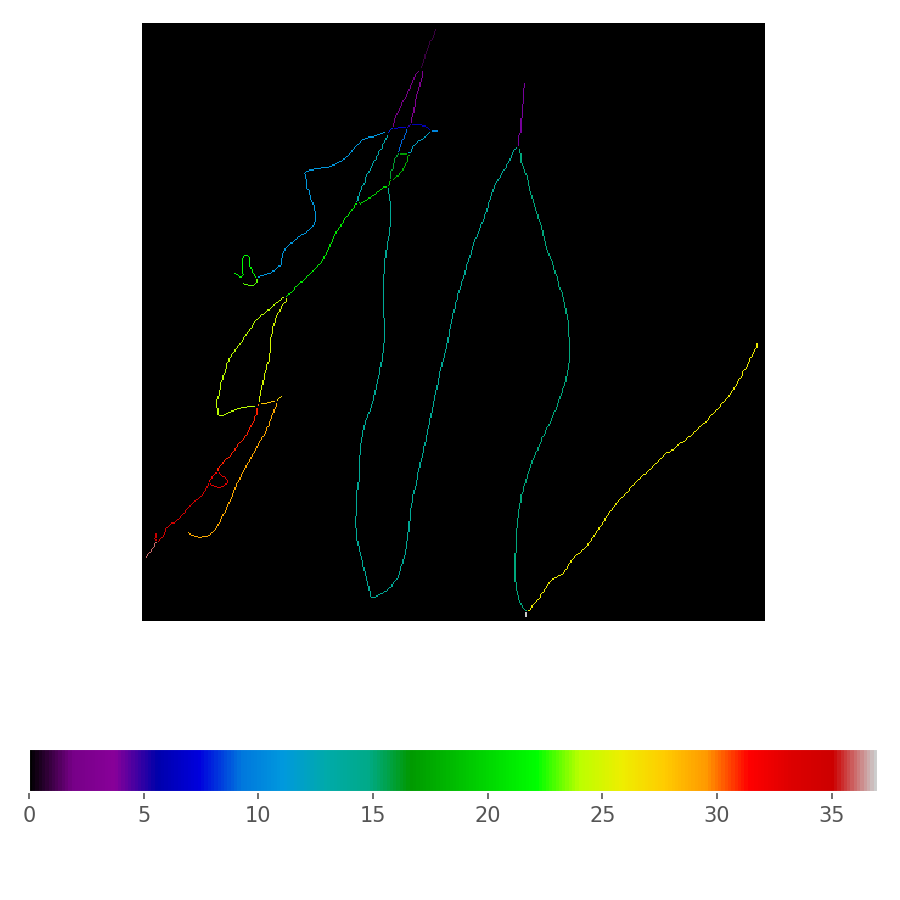

In [54]:
fig, m_axs = plt.subplots(1,1, figsize=(6,6), dpi=150)
im = m_axs.imshow(branch_label_img, cmap='nipy_spectral', interpolation='none')
m_axs.axis('off')
fig.colorbar(im, ax=m_axs, orientation='horizontal')
plt.show()
fig.tight_layout()
plt.savefig(r'images\sampleV07PO02_edges_notclean.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

<IPython.core.display.Javascript object>


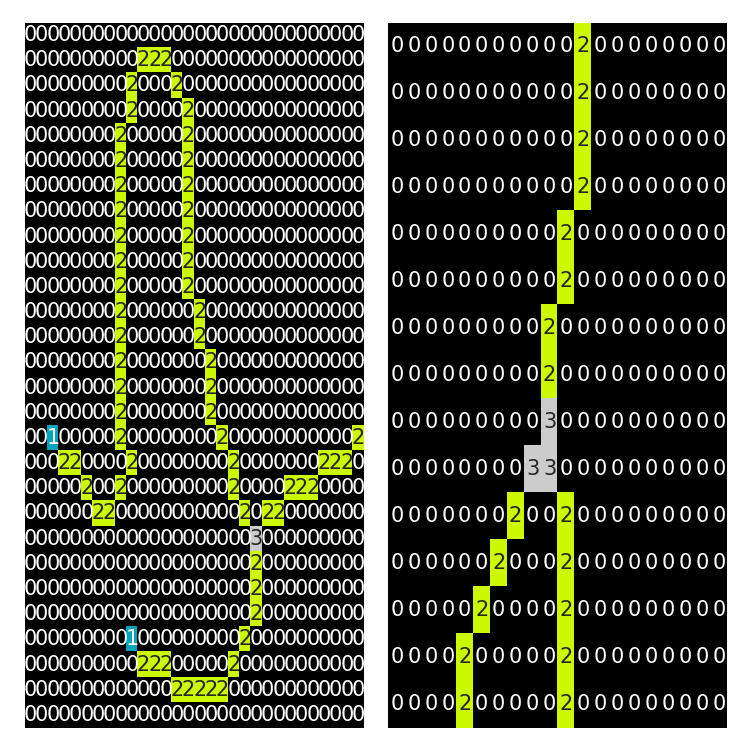

In [55]:
fig, m_axs = plt.subplots(1, 2, figsize = (5,5), dpi=150)
sns.heatmap(img_nn[190:218, 74:104], annot=True, ax=m_axs[0], 
            fmt="d", cmap='nipy_spectral', cbar=False)
sns.heatmap(img_nn[30:45, 220:240], annot=True, ax=m_axs[1], 
            fmt="d", cmap='nipy_spectral', cbar=False)
m_axs[0].axis('off')
m_axs[1].axis('off')
plt.show()
fig.tight_layout()

Two examples of intersections and end points. In the right one, this will give issues when defining nodes. We need only single 3 connection point. 

Sum of these intersections is greater than the correct intersection. We can sum NN image and threshold to isolate these. We can then apply morphological operaion to isolate to single pixel.
- From original NN, get intersection n>= 3 and perform labelling of edges as normal. 
- Get cleaned nodes. 
- Overwrite with corrected nodes.

In [56]:
def sum_nearest_neighbours(in_img, k):
    a = np.where(in_img > 0, 1, 0)
    a_nn = ndimage.convolve(in_img, k, mode='constant', cval=0.0)
    return (a_nn * a).astype(np.uint8)

Get problem locations by using sum NN - use k_nn

In [57]:
def get_edges(labelled_img, nodes):
    img_x, img_y = labelled_img.shape
    z_nn = labelled_img
    edges = []
    for x,y in nodes:
        nn = np.asarray([z_nn[(x-1) % img_x, (y+1) % img_y],z_nn[x+0, (y+1) % img_y],z_nn[(x+1) % img_x, (y+1) % img_y],
                         z_nn[(x-1) % img_x,  y+0],                                  z_nn[(x+1) % img_x,  y+0],
                         z_nn[(x-1) % img_x, (y-1) % img_y],z_nn[x+0, (y-1) % img_y],z_nn[(x+1) % img_x, (y-1) % img_y]])
        edges.append(nn[nn != 0])

    return edges

In [58]:
def clean_labelled(in_img, label_img):
    
    k_nn = np.array([[1,1,1],[1,0,1],[1,1,1]])
    k_cross = np.array([[0,1,0],[1,0,1],[0,1,0]])
    
    img_2_conn_sum = sum_nearest_neighbours(in_img, k_nn)
    img_1_conn_sum = sum_nearest_neighbours(in_img, k_cross)
    
    tmp_nodes = np.where(img_2_conn_sum >= 8)    
    tmp_nodes = list(zip(*tmp_nodes))
    edges_around_nodes = get_edges(label_img, tmp_nodes)
    for i, (x,y) in enumerate(tmp_nodes):
        if len(edges_around_nodes[i]) > 0:
            label_img[x,y] = edges_around_nodes[i]
    
    tmp_nn = (img_1_conn_sum>=3)*(img_1_conn_sum<=5) #incorrect intersections
    img_cleaned_nn = np.where(tmp_nn==True, 2, in_img) # reset to 'corrected' NN to value of 2
    return img_cleaned_nn, label_img

In [59]:
img_cleaned_nn, img_cleaned_label = clean_labelled(img_nn, branch_label_img)

<IPython.core.display.Javascript object>


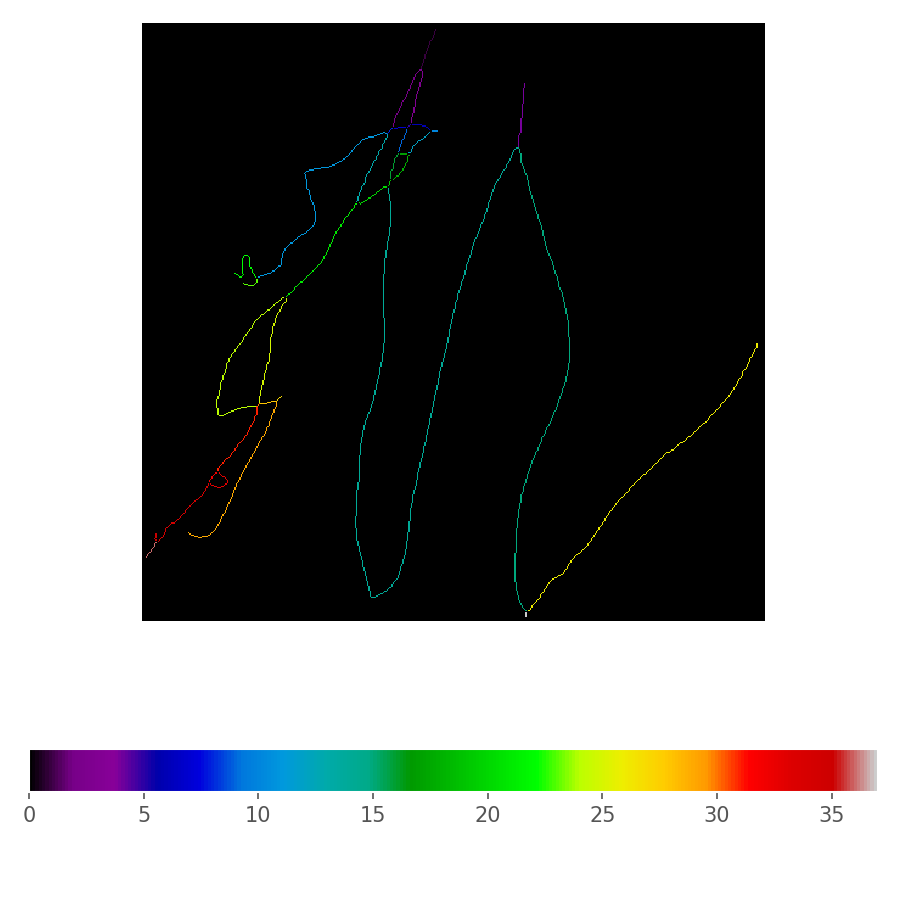

In [60]:
fig, m_axs = plt.subplots(1,1, figsize=(6,6), dpi=150)
im = m_axs.imshow(img_cleaned_label, cmap='nipy_spectral', interpolation='none')
m_axs.axis('off')
fig.colorbar(im, ax=m_axs, orientation='horizontal')
plt.show()
fig.tight_layout()
plt.savefig(r'images\sampleV07PO02_edges_clean.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

<IPython.core.display.Javascript object>


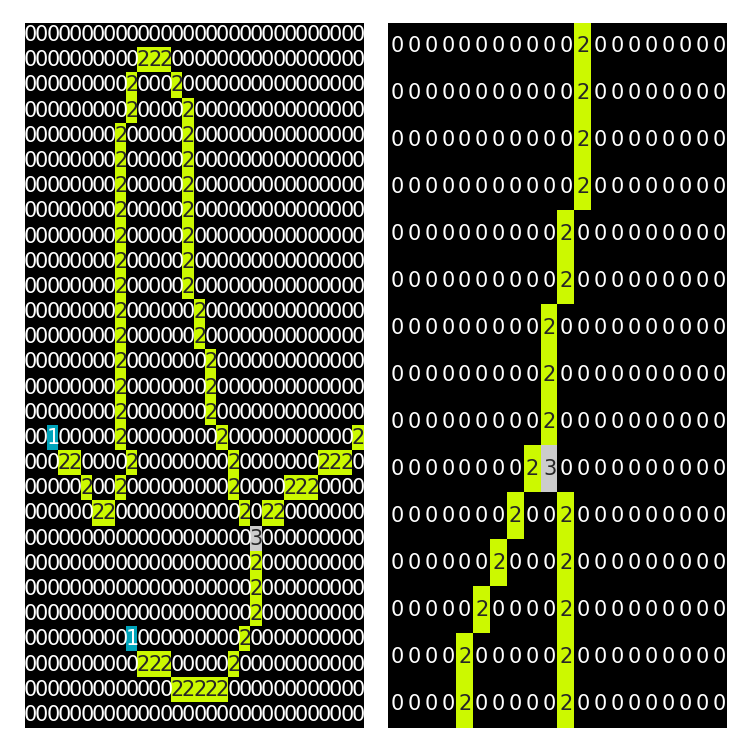

In [61]:
fig, m_axs = plt.subplots(1, 2, figsize = (5,5), dpi=150)
sns.heatmap(img_cleaned_nn[190:218, 74:104], annot=True, ax=m_axs[0], 
            fmt="d", cmap='nipy_spectral', cbar=False)
sns.heatmap(img_cleaned_nn[30:45, 220:240], annot=True, ax=m_axs[1], 
            fmt="d", cmap='nipy_spectral', cbar=False)
m_axs[0].axis('off')
m_axs[1].axis('off')
plt.show()
fig.tight_layout()

Get nodes (intersection) locations

In [62]:
nodes_3 = np.where(img_cleaned_nn == 3) # nodes position
nodes_3 = list(zip(*nodes_3))
nodes_1 = np.where(img_cleaned_nn == 1) # nodes position
nodes_1 = list(zip(*nodes_1))
all_nodes = nodes_1 + nodes_3

In [63]:
print(all_nodes)

[(6, 241), (50, 314), (89, 242), (206, 76), (214, 83), (264, 505), (307, 114), (419, 38), (420, 11), (439, 3), (488, 315), (39, 229), (83, 221), (86, 206), (87, 217), (89, 237), (91, 201), (103, 309), (107, 211), (108, 218), (129, 205), (135, 201), (148, 177), (210, 94), (226, 117), (311, 110), (313, 96), (315, 94), (369, 62), (378, 55), (426, 12), (484, 316)]


View the edges and intersection points as defined by drawing on image

In [64]:
# edge points
ep = np.where(img_nn == 1) # end nodes position
ep = list(zip(*ep))
# intersections
intersections = np.where(img_cleaned_nn == 3) # nodes position
intersections = list(zip(*intersections))

In [65]:
img_nn_copy = np.copy(img_cleaned_nn)

In [66]:
# add edge points to image
for x,y in ep:
    rr,cc = draw.disk((x,y),2)
    img_nn_copy[rr, cc] = 50

In [67]:
# add intersections also to image
for x,y in intersections:
    rr,cc = draw.disk((x,y),2)
    img_nn_copy[rr, cc] = 100

<IPython.core.display.Javascript object>


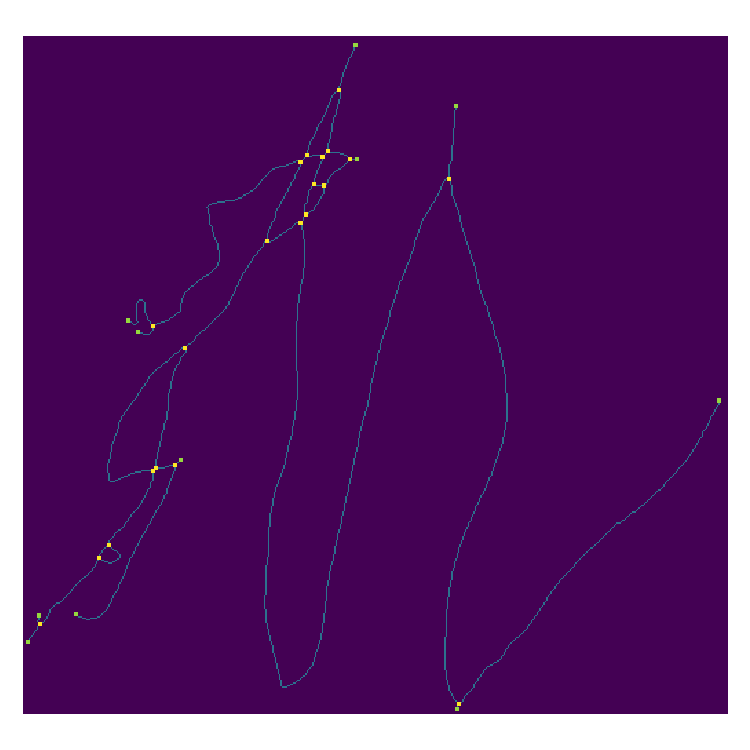

In [68]:
fig, m_axs = plt.subplots(1, 1, figsize = (5,5), dpi=150)
m_axs.imshow(img_nn_copy, interpolation='none', norm=mpl.colors.PowerNorm(gamma=0.25))
m_axs.axis('off')
plt.show()
fig.tight_layout()

In [73]:
node_edges = get_edges(img_cleaned_label, all_nodes) #edges at each node
node_edges

[array([1], dtype=int64),
 array([4], dtype=int64),
 array([10], dtype=int64),
 array([22], dtype=int64),
 array([23], dtype=int64),
 array([26], dtype=int64),
 array([27], dtype=int64),
 array([29], dtype=int64),
 array([35], dtype=int64),
 array([36], dtype=int64),
 array([37], dtype=int64),
 array([3, 1, 2], dtype=int64),
 array([6, 3, 5], dtype=int64),
 array([7, 2, 8], dtype=int64),
 array([5, 9, 7], dtype=int64),
 array([10,  6, 12], dtype=int64),
 array([ 8, 13, 11], dtype=int64),
 array([15,  4, 14], dtype=int64),
 array([17,  9, 16], dtype=int64),
 array([12, 18, 17], dtype=int64),
 array([18, 16, 19], dtype=int64),
 array([19, 14, 20], dtype=int64),
 array([20, 13, 21], dtype=int64),
 array([11, 23, 22], dtype=int64),
 array([21, 25, 24], dtype=int64),
 array([27, 29, 28], dtype=int64),
 array([28, 25, 30], dtype=int64),
 array([30, 31, 24], dtype=int64),
 array([33, 31, 32], dtype=int64),
 array([33, 32, 34], dtype=int64),
 array([34, 35, 36], dtype=int64),
 array([26, 15, 3

In [74]:
len(node_edges)

32

In [75]:
edge_int = list(range(1,max(map(max, node_edges))+1))
print(edge_int)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [78]:
# for each edge, check each node
#### Get which nodes are connected by edges
def get_edges_as_nodes(edge_int, node_edges):
    edges = []
    for edge_id in edge_int:
        connection = []
        for node_id in range(len(node_edges)): #j,k in enumerate try
            #print([k for k, e in enumerate(node_edges[j]) if e == i])
            e = np.where(node_edges[node_id] == edge_id)[0]
            if e.size > 0:
                #print(e, edge_id, node_id+1) #position around node, edge id, connecting to node j
                connection.append(node_id+1)
        if len(connection) == 1:
            edges.append(tuple((connection[0],connection[0]))) #TEST
        else:
            edges.append(tuple(connection))
    return edges
    #edge ID is index (+1), nodes connected by edge. Need only 2. See above           

In [79]:
edges = get_edges_as_nodes(edge_int, node_edges)

In [76]:
def get_edge_length(label_img, edge_list):
    edge_length = []
    for edge in edge_list:
        length = np.sum(np.where(label_img == edge, 1, 0))
        edge_length.append(length)
    return edge_length

In [77]:
edge_lengths = get_edge_length(img_cleaned_label, edge_int)

In [80]:
edge_data = []
for i,(j,k) in enumerate(edges):
    edge_data.append(((j,k), {'weight':edge_lengths[i]}))

In [81]:
# create graph
# G = nx.Graph()
G = nx.MultiGraph()
edge_number = G.add_edges_from(edges)
#G.add_edges_from(edge_data)

In [82]:
print(list(zip(edges, edge_number)))

[((1, 12), 0), ((12, 14), 0), ((12, 13), 0), ((2, 18), 0), ((13, 15), 0), ((13, 16), 0), ((14, 15), 0), ((14, 17), 0), ((15, 19), 0), ((3, 16), 0), ((17, 24), 0), ((16, 20), 0), ((17, 23), 0), ((18, 22), 0), ((18, 32), 0), ((19, 21), 0), ((19, 20), 0), ((20, 21), 0), ((21, 22), 0), ((22, 23), 0), ((23, 25), 0), ((4, 24), 0), ((5, 24), 0), ((25, 28), 0), ((25, 27), 0), ((6, 32), 0), ((7, 26), 0), ((26, 27), 0), ((8, 26), 0), ((27, 28), 0), ((28, 29), 0), ((29, 30), 0), ((29, 30), 1), ((30, 31), 0), ((9, 31), 0), ((10, 31), 0), ((11, 32), 0)]


In [83]:
for i,(j,k) in enumerate(edges):
    G[j][k][edge_number[i]]['edge_id'] = i+1
    G[j][k][edge_number[i]]['weight'] = edge_lengths[i]

In [84]:
nx.is_weighted(G)

True

In [85]:
G.edges(data='weight', keys=True)

MultiEdgeDataView([(1, 12, 0, 33), (12, 14, 0, 47), (12, 13, 0, 44), (14, 15, 0, 10), (14, 17, 0, 5), (13, 15, 0, 3), (13, 16, 0, 15), (2, 18, 0, 53), (18, 22, 0, 715), (18, 32, 0, 381), (15, 19, 0, 19), (16, 3, 0, 5), (16, 20, 0, 21), (17, 24, 0, 167), (17, 23, 0, 56), (19, 21, 0, 21), (19, 20, 0, 6), (24, 4, 0, 44), (24, 5, 0, 14), (20, 21, 0, 22), (23, 22, 0, 23), (23, 25, 0, 80), (22, 21, 0, 5), (32, 6, 0, 234), (32, 11, 0, 4), (25, 28, 0, 132), (25, 27, 0, 86), (28, 27, 0, 3), (28, 29, 0, 54), (27, 26, 0, 13), (7, 26, 0, 5), (26, 8, 0, 127), (29, 30, 0, 9), (29, 30, 1, 24), (30, 31, 0, 51), (31, 9, 0, 6), (31, 10, 0, 13)])

In [130]:
all_nodes_x, all_nodes_y = zip(*all_nodes)

In [86]:
def get_wave_source_dest(all_nodes):
    all_nodes_x, all_nodes_y = zip(*all_nodes)
    source = all_nodes_y.index(min(all_nodes_y))
    dest = all_nodes_y.index(max(all_nodes_y))
    return source, dest

In [107]:
def get_spiral_source_dest(al_ep, img_shape):
    # approximation by node closest to the center of image
    c_x, c_y = img_shape
    c_x, c_y = c_x // 2, c_y // 2
    all_ep_x, all_ep_y = zip(*al_ep)
    source = al_ep.index(min(al_ep, key=lambda c: (c[0] - c_x)**2 + (c[1] - c_y)**2))
    dest = al_ep.index(max(al_ep, key=lambda c: (c[0] - c_x)**2 + (c[1] - c_y)**2))
    return source, dest

In [87]:
def get_weight(G, edge_number, path):
    total = 0
    for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
        print(i, edge_number[i], path)
        total += G.edges[u,v,edge_number[i]]['weight']
    return total

In [88]:
def get_edge_labels(G, node_path, edge_number):
    edge_list = []
    for i, (u, v) in enumerate(zip(node_path[:-1], node_path[1:])):
        edge_list.append(G.edges[u,v,edge_number[i]]['edge_id'])
    return edge_list

In [90]:
def get_weights_and_edges(G, path):
    edges_x, edges_y, ident, weights = zip(*list(G.edges(data='weight', keys=True)))
    edge_arr_x = np.array(list(edges_x))
    edge_arr_y = np.array(list(edges_y))

    weight_total = 0
    edge_ident = []
    for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
        index = np.where(np.logical_and(edge_arr_x == u, edge_arr_y == v))[0]
        if len(index) == 0:
            index = np.where(np.logical_and(edge_arr_x == v, edge_arr_y == u))[0]
        # weight_total += max([weights[x] for x in index])
        maxi = 0
        for x in index:
            tmp = weights[x]
            if tmp >= maxi:
                maxi = tmp
                indi = ident[x]

        weight_total += maxi
        edge_ident.append(indi)
    return weight_total, edge_ident

In [94]:
def get_node_labels(node_path, edge_ident):
    i = 0
    node_list = []
    for ident in edge_ident:
        if ident == 0:
            node_list.append(node_path[i])
            i += 1
        else:
            i = i+1
            node_list.append(node_path[i])
            node_list.append(node_path[i]+1)
            i += 1
    node_list.append(node_path[-1])
    node_list = list(set(node_list))
    return node_list

In [91]:
source, dest = get_wave_source_dest(nodes_1)

In [92]:
source = source + 1
dest = dest + 1 # for G, index starts at 1

In [95]:
simple_path_edge_labels = []
simple_path_weights_list = []
img_node_list = []
for j,path in enumerate(nx.all_simple_paths(G, source, dest)):
    if j % 2 == 0:
#         print(j)
#         print(path, len(path))
#         print(list(zip(path[:-1], path[1:])), len(list(zip(path[:-1], path[1:]))))
        path_info = get_weights_and_edges(G,path)
#         print(path_info[1], len(path_info[1]))
        simple_path_edge_labels.append(get_edge_labels(G, path, path_info[1]))
        simple_path_weights_list.append(path_info[0])
        img_node_list.append(get_node_labels(path, path_info[1]))

In [96]:
heavy_path_idx = np.argmax(simple_path_weights_list, axis=0)
heaviest_path_nodes = list(nx.all_simple_paths(G, source, dest))[heavy_path_idx]
print('Nodes:', heaviest_path_nodes)
heaviest_path_edge_labels = simple_path_edge_labels[heavy_path_idx]
print('Edge Labels:', heaviest_path_edge_labels) #Label on image
print('Length:', simple_path_weights_list[heavy_path_idx])

Nodes: [10, 31, 30, 29, 28, 25, 23, 17, 14, 12, 13, 15, 19, 20, 21, 22, 18, 32, 6]
Edge Labels: [36, 34, 33, 31, 24, 21, 13, 8, 2, 3, 6, 12, 17, 16, 19, 14, 15, 26]
Length: 1904


In [97]:
# cleaned sketch
img_cleaned_sketch = np.isin(img_cleaned_label, heaviest_path_edge_labels).astype(np.uint8)
img_cleaned_sketch = img_cleaned_label * img_cleaned_sketch

<IPython.core.display.Javascript object>


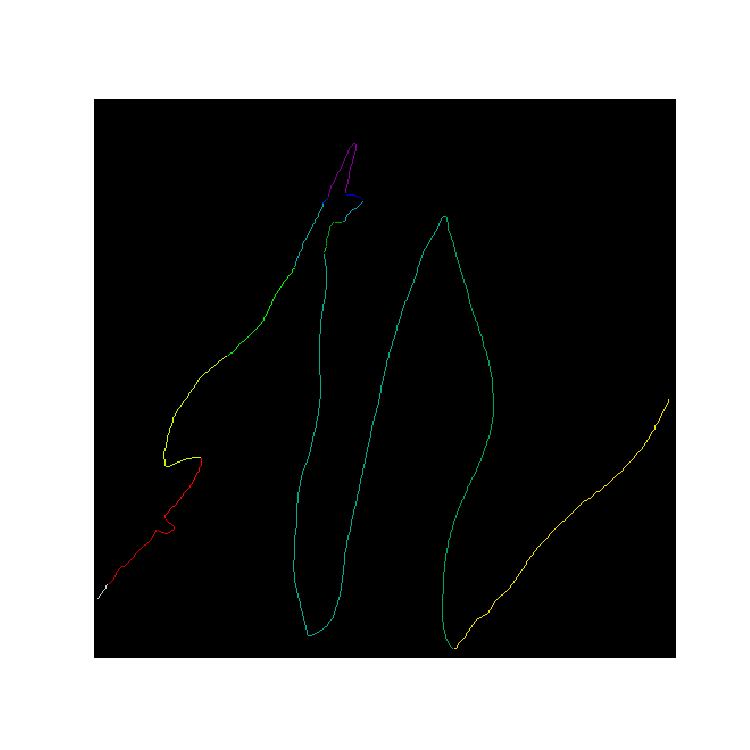

In [98]:
fig, m_axs = plt.subplots(1,1, figsize=(5,5), dpi=150)
m_axs.imshow(img_cleaned_sketch, interpolation='none', cmap='nipy_spectral')
m_axs.axis('off')
plt.show()
# fig.savefig(r'images\label_edges_cleaned.png', dpi=150, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)

In [99]:
nx.get_edge_attributes(G,'edge_id')

{(1, 12, 0): 1,
 (12, 14, 0): 2,
 (12, 13, 0): 3,
 (14, 15, 0): 7,
 (14, 17, 0): 8,
 (13, 15, 0): 5,
 (13, 16, 0): 6,
 (2, 18, 0): 4,
 (18, 22, 0): 14,
 (18, 32, 0): 15,
 (15, 19, 0): 9,
 (16, 3, 0): 10,
 (16, 20, 0): 12,
 (17, 24, 0): 11,
 (17, 23, 0): 13,
 (19, 21, 0): 16,
 (19, 20, 0): 17,
 (24, 4, 0): 22,
 (24, 5, 0): 23,
 (20, 21, 0): 18,
 (23, 22, 0): 20,
 (23, 25, 0): 21,
 (22, 21, 0): 19,
 (32, 6, 0): 26,
 (32, 11, 0): 37,
 (25, 28, 0): 24,
 (25, 27, 0): 25,
 (28, 27, 0): 30,
 (28, 29, 0): 31,
 (27, 26, 0): 28,
 (7, 26, 0): 27,
 (26, 8, 0): 29,
 (29, 30, 0): 32,
 (29, 30, 1): 33,
 (30, 31, 0): 34,
 (31, 9, 0): 35,
 (31, 10, 0): 36}

# VISUALIZATION

<IPython.core.display.Javascript object>


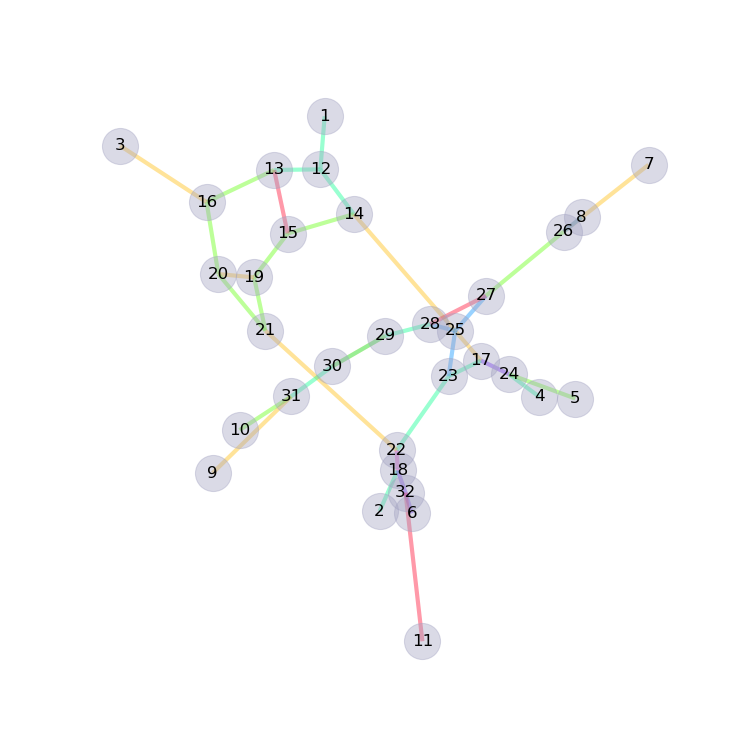

In [100]:
edge_labels = nx.get_edge_attributes(G,'edge_id')
Gedges,Gweights = zip(*nx.get_edge_attributes(G,'weight').items())
weights_norm = list(map(int,np.log(((Gweights - min(Gweights)) / (max(Gweights) - min(Gweights))) * max(Gweights)+1)))
pos=nx.spring_layout(G)
#pos = nx.random_layout(G, seed=42)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.planar_layout(G)
#pos = nx.spectral_layout(G)
color_range = range(len(edges))
fig, m_axs = plt.subplots(1,1, figsize=(5,5), dpi=150)
nx.draw_networkx_nodes(G,pos,node_color='#a3a3c2',alpha=0.4)
nx.draw_networkx_edges(G,pos,alpha=0.4,node_size=0,width=2, edge_color=weights_norm, edge_cmap=plt.cm.gist_rainbow)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
# nx.draw(G,pos,edge_color=color_range,edge_cmap=plt.cm.nipy_spectral, with_labels=False)
# nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
m_axs.axis('off')
# plt.savefig(r'images\network.png', dpi=150, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)
plt.show()

In [101]:
logmin = np.log(min(Gweights))
logmax = np.log(max(Gweights))
weights_norm = list((np.log(Gweights) - logmin) / (logmax - logmin))

In [102]:
cmap = plt.cm.get_cmap('gist_rainbow')
weight_colors = list(map(cmap, Gweights)) #(1.0, 0.0, 0.0972549019607843, 1.0)
weight_norm_colors = list(map(cmap, weights_norm)) #(1.0, 0.0, 0.0972549019607843, 1.0)
hex_colors = []
hex_norm_colors = []
for color in weight_colors:
    rgb = color[:-1] # will return rgba, we take only first 3 so we get rgb
    hex_colors.append(mpl.colors.rgb2hex(rgb))
for color in weight_norm_colors:
    rgb = color[:-1] # will return rgba, we take only first 3 so we get rgb
    hex_norm_colors.append(mpl.colors.rgb2hex(rgb))

<IPython.core.display.Javascript object>


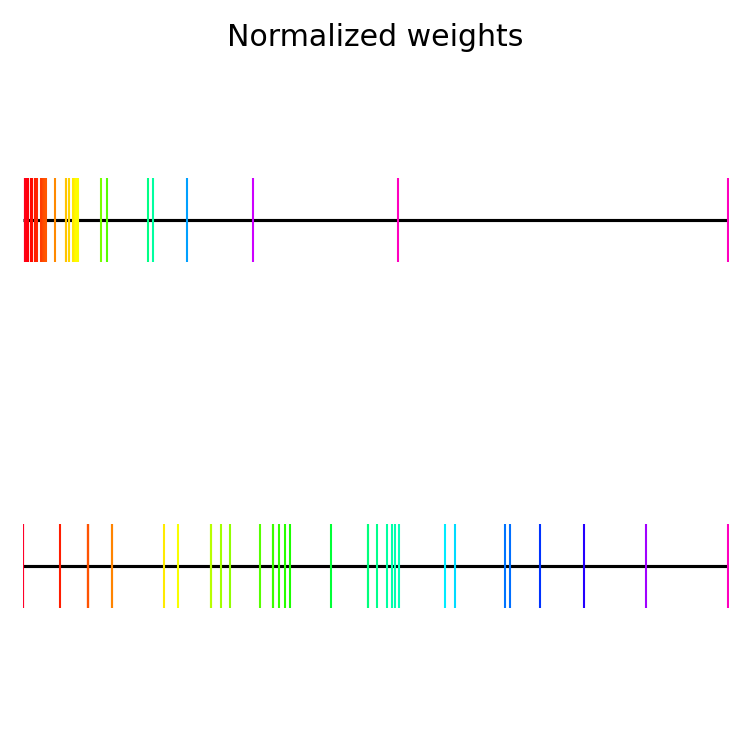

In [103]:
fig, m_axs = plt.subplots(2,1, figsize=(5,5), dpi=150)

m_axs[0].set_title('Pixel length weights')
m_axs[0].hlines(1,0,max(Gweights))  # Draw a horizontal line
m_axs[0].set_xlim(0,max(Gweights))
m_axs[0].set_ylim(0.5,1.5)
for i, weight in enumerate(Gweights):
    m_axs[0].plot(weight,1,'|',ms = 40,color=hex_colors[i])  # Plot a line at each location specified in a
m_axs[0].axis('off')

m_axs[0].set_title('Normalized weights')
m_axs[1].hlines(1,0,max(weights_norm))  # Draw a horizontal line
m_axs[1].set_xlim(0,max(weights_norm))
m_axs[1].set_ylim(0.5,1.5)
for i, weight in enumerate(weights_norm):
    m_axs[1].plot(weight,1,'|',ms = 40,color=hex_norm_colors[i])
m_axs[1].axis('off')

fig.tight_layout()
# plt.savefig(r'images\norm_weights_vis.png', dpi=150, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.0, metadata=None)
plt.show()

In [104]:
edge_colors = list(map(cmap, weights_norm)) #(1.0, 0.0, 0.0972549019607843, 1.0)
hex_colors = []
for color in edge_colors:
    rgb = color[:-1] # will return rgba, we take only first 3 so we get rgb
    hex_colors.append(mpl.colors.rgb2hex(rgb))

In [105]:
for i,edge in enumerate(G.edges(data=True)): 
    edge[2]['label'] = edge[2]['weight']

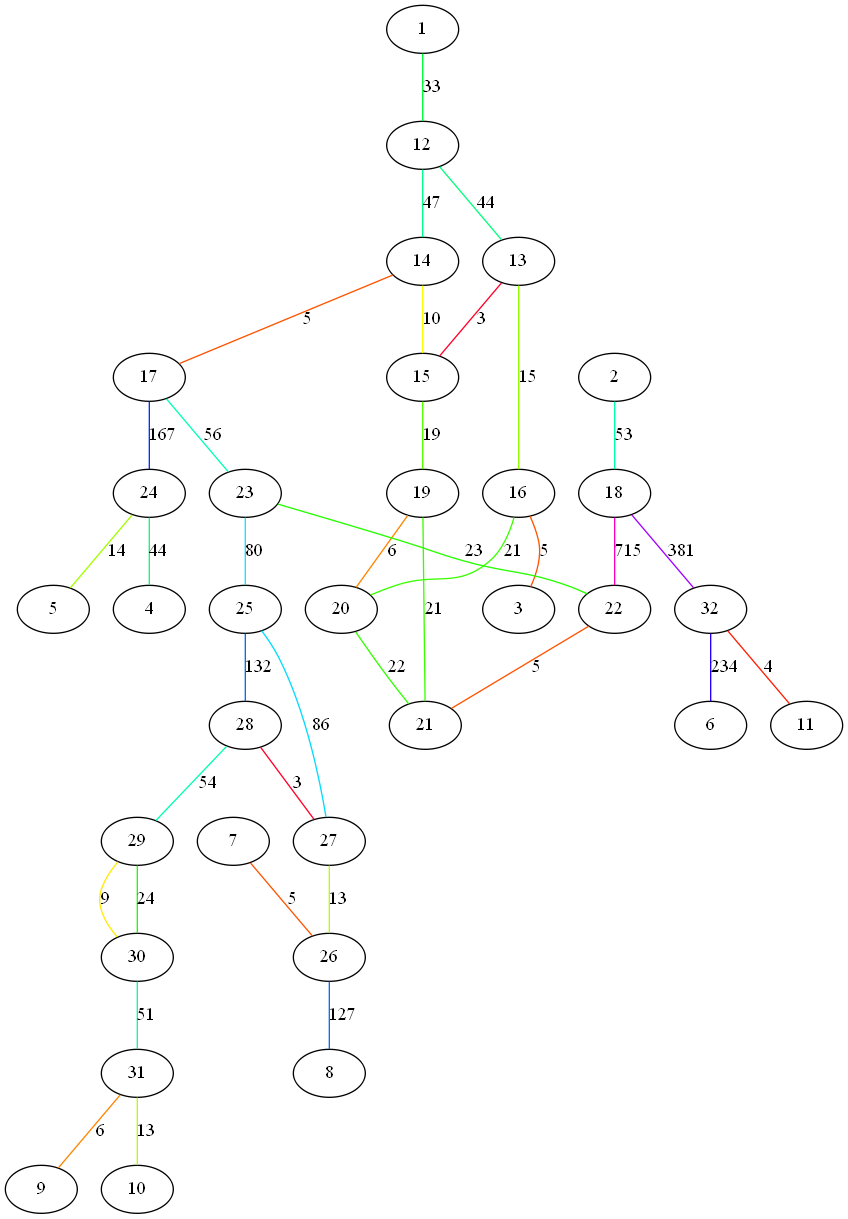

In [106]:
node_label = nx.get_node_attributes(G,'id')
pos = nx.spring_layout(G)
p=nx.drawing.nx_pydot.to_pydot(G)
for i, edge in enumerate(p.get_edges()):
    #edge.set_label("e%d" % i)
    #edge.set_fontcolor(colors[random.randrange(len(colors))])
    #edge.set_style(styles[random.randrange(len(styles))])
    edge.set_color(hex_colors[i])
    
p.write_png('images\multi_norm.png')
Image(filename='images\multi_norm.png')

In [ ]:
from string import ascii_lowercase   
try:
    assert len(nodes) < len(ascii_lowercase)
    node_names = [ascii_lowercase[i] for i in range(len(nodes))]
except AssertionError:
    print('Error')
res = dict(zip(node_names, node_edges))
node_edge_tuples = list(map(tuple, node_edges)) # what edges nodes are connected to